In [1]:
%matplotlib notebook
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import itertools
from IPython.core.debugger import set_trace
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import collections
import random


# Check cuda.is_available ?

In [2]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("cuda_available : {}, device : {}".format(cuda_available, device))

cuda_available : True, device : cuda:0


In [3]:
class ParkinsonDataset(Dataset):
    def __init__(self, 
                 task_type,
                 train_or_test,
                 split_ratio=(0.8, 0.2),
                 UDysRS_rating_file = './UDysRS_UPDRS_Export/UDysRS.txt',
                 UPDRS_rating_file = './UDysRS_UPDRS_Export/UPDRS.txt',
                 CAPSIT_rating_file = './UDysRS_UPDRS_Export/CAPSIT.txt',
                 sn_file = './UDysRS_UPDRS_Export/sn_numbers.txt',
                 maxlen=1000,
                 seed=5
                ):
        
        
        self.maxlen = maxlen

        # support 2 type of tasks ( A : "Communication/Drinking Tasks",
        #                           B : "Leg Agility Task" )
        trajectory_file = './UDysRS_UPDRS_Export/Communication_all_export.txt' if task_type=='typeA' else \
                              './UDysRS_UPDRS_Export/LA_split_all_export.txt'

        
        def load_data(file_path):
            with open(file_path, 'r') as infile:
                data = json.load(infile)
            return data

        # input data
        traj_data = load_data(trajectory_file)
        
        # target data
        rating_data = {k:load_data(v) for k,v in zip(['UDysRS',
                                                      'UPDRS',
                                                      'CAPSIT'],
                                                      [UDysRS_rating_file,
                                                       UPDRS_rating_file,
                                                       CAPSIT_rating_file])}

        # map : trial number -> subject name
        self.sn_map = load_data(sn_file)

        ## preprocess input data (trajectory)
        input_data = collections.defaultdict(list)
        
        if task_type=='typeB':
            for key,meta_dict in traj_data.items():
                
                all_body_parts = meta_dict['position'].keys()
                
                tmp_dict = collections.defaultdict(list)

                part_active = list(filter(lambda x: x.endswith('_act'), all_body_parts))
                part_rst = list(filter(lambda x: x.endswith('_rst'), all_body_parts))

                # add active data first
                for part in part_active:
                    pure_part = part.split('_')[0]
                    tmp_dict[pure_part] += meta_dict['position'][part]
                    
                # append rst data
                for part in part_rst:
                    pure_part = part.split('_')[0]
                    tmp_dict[pure_part] += meta_dict['position'][part]
                    
                
                # replace with modified tmp_dict
                traj_data[key]['position'] = tmp_dict
        
        
        for key,meta_dict in traj_data.items():
            n_joints = len(meta_dict['position'].keys())

            # time-major
            time_series_data = np.asanyarray(list(meta_dict['position'].values())).transpose(1,0,2)
            time_series_data = time_series_data.reshape(-1, n_joints*2)  # vectorisze; e.g. seq of position vectors
            
            input_data["sample_id"].append(key)
            input_data["trajectory"].append(time_series_data.tolist())        


            
        ## preprocess target data (trajectory)

        # prepare empty data
        target_data = collections.defaultdict(list)
        all_trials = list(self.sn_map.keys())
        
        # for "UDysRS"
        target_data["trial_nbr"] = all_trials
        for column_name in ['Communication', 'Drinking', 'Higher']:
            for part in [ "Neck", 
                          "Right arm/shoulder", "Left arm/shoulder",
                          "Trunk",
                          "Right leg/hip", "Left leg/hip" ]:
                target_data["UDysRS" + '_' + column_name + '_' + part] = [ np.nan ] * len(target_data["trial_nbr"])

        # for "UPDRS"
        target_data["UPDRS_Total"] = [ np.nan ] * len(target_data["trial_nbr"])            
        
        
        RaitingItem2Name = { 
                            k: v for k,v in zip(['3.1', '3.10', '3.4', '3.5', '3.6', '3.8', '3.9'],
                                                ['SPEECH', 'GAIT', 'FINGER TAPPING', 'HAND MOVEMENTS', 
                                                 'PRONATION-SUPINATION MOVEMENTS OFHANDS', 'LEG AGILITY', 'ARISING FROM CHAIR']
                                               )
                          }
        
        # for CAPSIT
        for column_name in rating_data['CAPSIT'].keys():
            for part in [ "Neck", 
                          "Trunk", 
                          "Upper limb right","Upper limb left",
                          "Lower limb right", "Lower limb left" ]:
                target_data["CAPSIT" + '_' + RaitingItem2Name[column_name] + '_' + part] = [ np.nan ] * len(target_data["trial_nbr"])

        
        # part 1 : 'UDysRS'            
        for column_name, meta_dict in rating_data['UDysRS'].items():
            trial_nbrs = meta_dict.keys()
            for trial_nbr in trial_nbrs:
                try:
                    ix = all_trials.index(trial_nbr)
                except ValueError:
                    # if trial_nbr is not found in all_trials, Skip
                    continue
                    
                for p_ix, part in enumerate([ "Neck", 
                                              "Right arm/shoulder", "Left arm/shoulder",
                                              "Trunk",
                                              "Right leg/hip", "Left leg/hip"]):
                    target_data["UDysRS" + '_' + column_name + '_' + part][ix] = meta_dict[trial_nbr][p_ix]

                
        
            
        # part 2 : 'UPDRS'
        for trial_nbr, val in rating_data['UPDRS']['Total'].items():
            try:
                ix = all_trials.index(trial_nbr)
            except ValueError:
                # if trial_nbr is not found in all_trials, Skip!
                continue

            target_data["UPDRS_Total"][ix] = val

            
        # part 3 : 'CAPSIT'
        for column_name, meta_dict in rating_data['CAPSIT'].items():
            trial_nbrs = meta_dict.keys()
            for trial_nbr in trial_nbrs:
                try:
                    ix = all_trials.index(trial_nbr)
                except ValueError:
                    # if trial_nbr is not found in all_trials, Skip
                    continue
                    
                for p_ix, part in enumerate([ "Neck", 
                                              "Trunk", 
                                             "Upper limb right","Upper limb left",
                                              "Lower limb right", "Lower limb left" ]):
                    target_data["CAPSIT" + '_' + RaitingItem2Name[column_name] + '_' + part][ix] = meta_dict[trial_nbr][p_ix]
        

        # input data frame
        input_df = pd.DataFrame(data=input_data).fillna(0)

        # integratged target data frame
        target_df = pd.DataFrame(data=target_data).fillna(0)
        
        # set random seed, to consistency of performance
        np.random.seed(seed)
        
        # shuffle before split
        input_df = input_df.iloc[np.random.permutation(len(input_df))]
        target_df = target_df.iloc[np.random.permutation(len(target_df))]
        
        if train_or_test=='train':
            self.input_df = input_df.iloc[:int(len(input_df)*split_ratio[0])]
            self.target_df = target_df
            
        elif train_or_test=='test':
            self.input_df = input_df.iloc[int(len(input_df)*split_ratio[0]):]
            self.target_df = target_df
        
    def __len__(self):
        return len(self.input_df)
    
    def __getitem__(self, idx):
        sample_id = self.input_df.iloc[idx].sample_id
        trial_nbr = sample_id.split('-')[0]
        
        input_data = self.input_df[self.input_df.sample_id==sample_id].iloc[:, 1:].values[0]
        target_data = self.target_df[self.target_df.trial_nbr==trial_nbr].iloc[:,1:].values[0]
        
        input_data = np.asanyarray(list(np.asanyarray(x) for x in input_data)).squeeze(axis=0)
        target_data = np.asanyarray(list(np.asanyarray(x) for x in target_data))
        
        # zero padding
        input_data = np.pad(input_data, ((0,self.maxlen-len(input_data)),(0,0)),
                                               'constant', constant_values=0).transpose(1,0)

        sample = { 'keypoints_seq': torch.tensor(input_data, dtype=torch.float32).cpu(),
                   'targets': torch.tensor(target_data, dtype=torch.float32).cpu()
        }
        
        return sample

In [4]:
mydataset = { x : ParkinsonDataset(task_type='typeA', train_or_test=x) \
                        for x in ['train', 'test'] }

dataloader = { x : DataLoader(mydataset[x],
                        batch_size=10,
                        shuffle=True,
                        num_workers=4) \
                    for x in ['train', 'test'] }

# Define DNN

In [5]:
class Conv1d(nn.Conv1d):
    def __init__(self, in_channels,
                       out_channels,
                       kernel_size,
                       stride=1,
                       padding=0,
                       dilation=1,
                       groups=1,
                       bias=True,
                       padding_type='same'):
        
        super(Conv1d, self).__init__(in_channels,
                                     out_channels,
                                     kernel_size,
                                     stride,
                                     padding,
                                     dilation,
                                     groups,
                                     bias)
        
        self.padding_type = padding_type
    
    def forward(self, x):
        _, _, input_length = x.size()
        
        if self.padding_type == 'same':
            padding_need = int((input_length * (self.stride[0]-1) + self.kernel_size[0] - self.stride[0]) / 2)
        
        return F.conv1d(x, self.weight, self.bias, self.stride, 
                        padding_need, self.dilation, self.groups)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, C, highway=True):
        super(ResidualBlock, self).__init__()
        self.highway = highway
        
        # pre-define bottle-neck structure
        
        # conv_1x1_a : reduce number of channels by factor of 4 (output_channel = C/4)
        self.conv_1x1_a = Conv1d(C, int(C/4), kernel_size=1, stride=1, padding_type='same')
        self.bn_1x1_a = nn.BatchNorm1d(int(C/4))
        
        # conv_3x3_b : more wide receptive field (output_channel = C/4)
        self.conv_3x3_b = Conv1d(int(C/4), int(C/4), kernel_size=3, stride=1, padding_type='same')
        self.bn_3x3_b = nn.BatchNorm1d(int(C/4))
        
        # conv_1x1_c : recover org channel C (output_channel = C)
        self.conv_1x1_c = Conv1d(int(C/4), C, kernel_size=1, stride=1, padding_type='same')
        self.bn_1x1_c = nn.BatchNorm1d(C)
        
        # conv_1x1_g : gating for highway network
        self.conv_1x1_g = Conv1d(C, C, kernel_size=1, stride=1, padding_type='same')
        
    
    def forward(self, x):
        '''
            x : size = (batch, C, maxlen)
        '''
        res = x        
    
        # 1x1_a (C/4)
        x = self.conv_1x1_a(x)
        x = self.bn_1x1_a(x)
        x = F.relu(x)
        
        # 3x3_b (C/4)
        x = self.conv_3x3_b(x)
        x = self.bn_3x3_b(x)
        x = F.relu(x)
        
        # 1x1_c (C)
        x = self.conv_1x1_c(x)
        x = self.bn_1x1_c(x)
        x = F.relu(x)
        
        
        if self.highway:
            # gating mechanism from "highway network"
            
            # gating factors controll intensity between x and f(x)
            # gating = 1.0 (short circuit) --> output is identity (same as initial input)
            # gating = 0.0 (open circuit)--> output is f(x) (case of non-residual network)
            gating = F.sigmoid(self.conv_1x1_g(x))
                                   
            # apply gating mechanism
            x = gating * res + (1.0 - gating) * x
            
        else:
            # normal residual ops (addition)
            x = x + res

        # apply relu for final output
        x = F.relu(x)
        
        return x

In [7]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)
    
class Net(nn.Module):
    def __init__(self, input_size, target_size, n_residual_blocks=4, residual_pooling_indices=range(0,4,2), C=256):
        assert max(residual_pooling_indices) < n_residual_blocks, "maxvalue of residual_pooling_indices ({}) cannot exceed n_residual_blocks ({})".format(max(residual_pooling_indices), n_residual_blocks)
        assert min(residual_pooling_indices) >= 0 , "minvalue of residual_pooling_indices ({}) cannot be smaller than 0".format(min(residual_pooling_indices))

        super(Net, self).__init__()
        
        self.input_size = input_size
        self.target_size = target_size
        
        residual_blocks = []
        pooling_cnt = 0 
        for i in range(n_residual_blocks):
            residual_blocks.append(ResidualBlock(C))
            if i in residual_pooling_indices:
                # every 2 residual, block pooling out!
                residual_blocks.append(nn.MaxPool1d((2,)))
                pooling_cnt += 1

        length_after_pooling = int(mydataset['train'].maxlen/(2**pooling_cnt))

        self.model = nn.Sequential(Conv1d(input_size, C, kernel_size=1, stride=1, padding_type='same'),
                                   nn.BatchNorm1d(C),
                                   nn.ReLU(),
                                   *residual_blocks,
                                   View(-1,C * length_after_pooling),
                                   nn.Linear(C * length_after_pooling, C),
                                   nn.ReLU(),
                                   nn.Linear(C, C),
                                   nn.ReLU(),
                                   nn.Linear(C, target_size)
                                   )
        
    def forward(self, x):
        '''
            x : size = (batch, input_size, maxlen)
        '''
        return self.model(x)
    
net = Net(input_size=np.array(mydataset['train'].input_df.trajectory[0]).shape[1],
          target_size=len(mydataset['train'].target_df.columns[1:]), n_residual_blocks=8, residual_pooling_indices=range(0,8,2), C=64)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
else:
    print("Single GPU mode")
    
net.to(device)

Single GPU mode


Net(
  (model): Sequential(
    (0): Conv1d(30, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualBlock(
      (conv_1x1_a): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
      (bn_1x1_a): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_3x3_b): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
      (bn_3x3_b): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1x1_c): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
      (bn_1x1_c): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1x1_g): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (4): MaxPool1d(kernel_size=(2,), stride=(2,), padding=0, dilation=1, ceil_mode=False)
    (5): ResidualBlock(
      (conv_1x1_a): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
      (bn_1x1_a): BatchNorm1d(16, eps=1e-05,

/home/hossay/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


==================TRAINING========================
EPOCH : 0, AVG_MSE : 8.3824
==================TESTING========================
EPOCH : 0, AVG_MSE : 7.3922
==================TRAINING========================
EPOCH : 1, AVG_MSE : 7.3337
==================TESTING========================
EPOCH : 1, AVG_MSE : 6.1351
==================TRAINING========================
EPOCH : 2, AVG_MSE : 6.2474
==================TESTING========================
EPOCH : 2, AVG_MSE : 5.1891
==================TRAINING========================
EPOCH : 3, AVG_MSE : 5.3542
==================TESTING========================
EPOCH : 3, AVG_MSE : 4.5393
==================TRAINING========================
EPOCH : 4, AVG_MSE : 4.7464
==================TESTING========================
EPOCH : 4, AVG_MSE : 4.2532
==================TRAINING========================
EPOCH : 5, AVG_MSE : 4.4617
==================TESTING========================
EPOCH : 5, AVG_MSE : 3.9972
==================TRAINING========================
EPOCH :

<IPython.core.display.Javascript object>


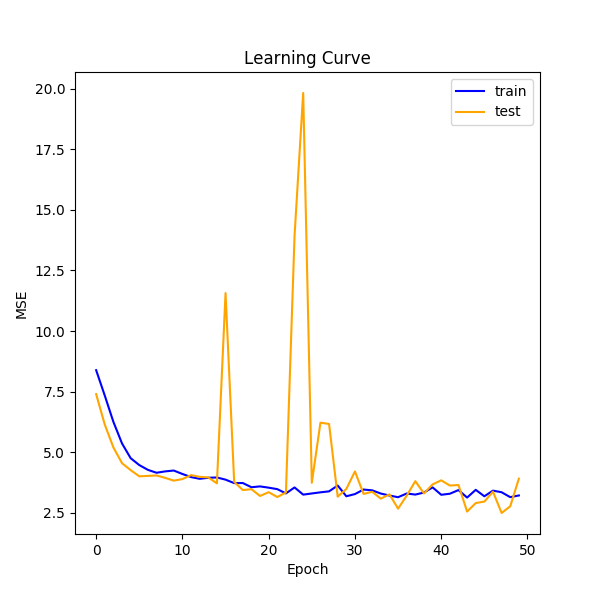

Saving learning curve...


In [8]:
# define criterion
criterion = nn.MSELoss()

history = {'train': [],
           'test': []}

import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-4)

for epoch in range(50):
    # training loop...
    running_loss = 0.0
    for idx, batch_item in enumerate(dataloader['train']):
        net.train()
        optimizer.zero_grad()
        
        input, target = batch_item['keypoints_seq'].to(device), batch_item['targets'].to(device)
        
        # feed data to network
        output = net(input)

        # compute loss
        loss = criterion(output, target)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

    # eval training loss
    steps_per_epoch = len(dataloader['train'].dataset)/dataloader['train'].batch_size
    avg_loss = running_loss / steps_per_epoch
    print('==================TRAINING========================')
    print('EPOCH : {}, AVG_MSE : {:.4f}'.format(epoch, avg_loss))
    
    history['train'].append(avg_loss)
    
    
    
    # test loop
    running_loss = 0.0
    for idx, batch_item in enumerate(dataloader['test']):
        net.eval()
        optimizer.zero_grad()
        
        input, target = batch_item['keypoints_seq'].to(device), batch_item['targets'].to(device)
        
        # feed data to network
        output = net(input)

        # compute loss
        loss = criterion(output, target)
        
        running_loss += loss.item()
        
    # eval test loss
    steps_per_epoch = len(dataloader['test'].dataset)/dataloader['test'].batch_size
    avg_loss = running_loss / steps_per_epoch
    print('==================TESTING========================')
    print('EPOCH : {}, AVG_MSE : {:.4f}'.format(epoch, avg_loss))    
    
    history['test'].append(avg_loss)

# plot learning curve
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(history['train'], label='train', color='b')
ax.plot(history['test'], label='test', color='orange')

ax.set_title('Learning Curve')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
plt.legend()

print("Saving learning curve...")
fig.savefig('learning.png', dpi=fig.dpi)